# Course Project


- Обучить двухуровневыю модель на retail_train.csv, для предсказаний использовать retail_test1.csv
- Целевая метрика precision@5 > 0.230 на тесте
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


### Импортирую нужные для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

# т.к. я не гружу из отдельного файла, а тут все алгоритмы предобработки прописал
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from sklearn.model_selection import GridSearchCV, KFold 

/home/kakorinis/anaconda3/envs/recsystems/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Алгоритмы предобработки, функции подсчета метрик, пайплайн (класс MainRecommender):

In [2]:
# обрезка датасета для обучения согласно легенде от полученного от бизнеса запроса
def prefilter_items(data, take_n_popular=5000, item_features=None): 

    # Уберем самые популярные товары (их и так купят)   
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() 
    
    n = data['user_id'].nunique()
    popularity['weight'] = [i/n for i in popularity['user_id']]
    top_popular = popularity[popularity['weight'] > 0.5].item_id.tolist()
    data = data.loc[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)       
    top_notpopular = popularity[popularity['weight'] < 0.01].item_id.tolist()
    data = data.loc[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    weeks_list = data.groupby('item_id')['week_no'].max().reset_index()
    weeks_list = weeks_list.loc[weeks_list.week_no < 82].item_id
    data = data.loc[~data['item_id'].isin(weeks_list.values)]

    # Уберем не интересные для рекоммендаций категории (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features. \
                                       groupby('department')['item_id'].nunique(). \
                                       sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[
            item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data.loc[~data['item_id'].isin(items_in_rare_departments)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data.loc[data['price'] > 2]

    # Уберем слишком дорогие товарыs
    data = data.loc[data['price'] < 50]
    
    # Возбмем топ по популярности
    popularity2 = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity2.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity2.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()
    
    # Заведем фиктивный item_id (если юзер покупал товары из топ-n, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999 # присваивается 999999 всем непопулярным
    
    return data


# Метрики
def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)

def precision_at_k(recommended_list, bought_list, k=5):
    return precision(recommended_list[:k], bought_list)

def recall(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(bought_list)

def recall_at_k(recommended_list, bought_list, k=5):
    return recall(recommended_list[:k], bought_list)

# посчтитать recall@k сразу по всем колонкам в сгрупп. таблице с рекомендациями и реально купленными товарами
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

# посчтитать precision@k агалогично
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()       

# Первая модель обучения ALS со всем препроцессингом для нее
class MainRecommender:

    def __init__(self, data: pd.DataFrame, weighting: bool = True):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
        self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data: pd.DataFrame):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id',
                                          columns='item_id',
                                          values='quantity',  #  можноо разное пробовать                                         aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    
    @staticmethod    # гиперпараметры подобраны в процессе настройки модели, здесь уже лучшие
    def fit(user_item_matrix, n_factors=96, regularization=0.1, iterations=15, num_threads=4):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():
            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                                                    user_items=csr_matrix(
                                                                        self.user_item_matrix).tocsr(),
                                                                    N=N,
                                                                    filter_already_liked_items=False,
                                                                    filter_items=[self.itemid_to_id[999999]],
                                                                    recalculate_user=False)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    
    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user_id, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user_id].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user_id, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""

        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user_id], N=N + 1)
        similar_users = [self.id_to_userid[rec[0]] for rec in similar_users]   # подбираем реальные id юзеров
        similar_users = similar_users[1:]  # удалим юзера из запроса

        for _user_id in similar_users:
            res.extend(self.get_own_recommendations(_user_id, N=1))

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

###  Загрузка данных:

In [3]:
data = pd.read_csv('/home/kakorinis/Desktop/GB/GeekBrains/II четверть/Рекомендательные системы/уроки с картинками/webinar_2/retail_train.csv')

item_features = pd.read_csv('/home/kakorinis/Desktop/GB/GeekBrains/II четверть/Рекомендательные системы/уроки с картинками/webinar_2/product.csv')

user_features = pd.read_csv('/home/kakorinis/Desktop/GB/GeekBrains/II четверть/Рекомендательные системы/уроки с картинками/webinar_2/hh_demographic.csv')


In [4]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Разбиение данных на трейн и тест (validation):

In [5]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# преобразовываем колонки одинаковым образом
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)


# РАЗДЕЛЯЕМ ДАТАСЕТ
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели - все что до последних 9 недель
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели - первые 6 недель после data_train_matcher
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели 
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели - последние 3 недели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [6]:
# смотрим соотношение данных
def print_stats_data(df_data, name_df):
    print('-'*60)
    print(f"{name_df}.shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")
    
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

------------------------------------------------------------
train_matcher.shape: (2108779, 12) Users: 2498 Items: 83685
------------------------------------------------------------
val_matcher.shape: (169711, 12) Users: 2154 Items: 27649
------------------------------------------------------------
train_ranker.shape: (169711, 12) Users: 2154 Items: 27649
------------------------------------------------------------
val_ranker.shape: (118314, 12) Users: 2042 Items: 24329


### ПРЕДОБРАБОТКА ДАННЫХ (урезаем объем):

In [7]:
data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000) #5000

print_stats_data(data_train_matcher,'train_matcher')

------------------------------------------------------------
train_matcher.shape: (541162, 13) Users: 2470 Items: 5001


In [8]:
data_train_matcher = data_train_matcher.drop('price', axis=1) # убрал price созданную под префильтром
data_train_matcher.head(2)                                    

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0
11,1364,26984896261,1,842930,1,2.19,31742,0.0,1520,1,0.0,0.0


### Убираем холодный старт 

Можно рекомендовать просто топ популярных товаров новым пользователям, но цель курсовой настроить непосредственно алгоритм предсказания рекомендаций теплым клиентов наилучшим образом  (фокус на тюнинг признаков и подбор гиперпараметров)

In [9]:
# Поэтому ищем общих пользователей и оставляем только их

common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

------------------------------------------------------------
train_matcher.shape: (541162, 12) Users: 2470 Items: 5001
------------------------------------------------------------
val_matcher.shape: (168867, 12) Users: 2135 Items: 27085
------------------------------------------------------------
train_ranker.shape: (168867, 12) Users: 2135 Items: 27085
------------------------------------------------------------
val_ranker.shape: (117836, 12) Users: 2029 Items: 24007


### Инициализирую модель первого уровня:

Примечание:
1) AlternatingLeastSquares c n_factors=96, regularization=0.1, iterations=15 - подобрал ранее лучшии гиперпараметры <br>
2) Веса взвешены через bm25_weight

Схема обучения первой модели применительно к набору data_train и data_val такова:

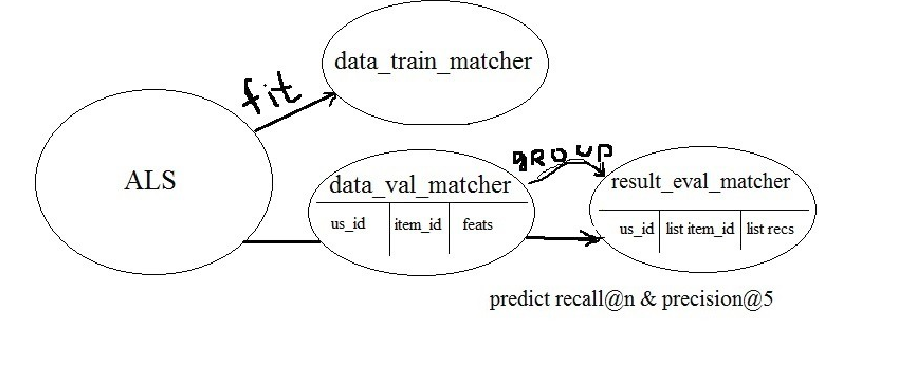

In [10]:
from IPython import display
display.Image('./scheme1.png', width=800)

In [11]:
recommender = MainRecommender(data_train_matcher)

100%|██████████| 5001/5001 [00:00<00:00, 9135.01it/s]


In [12]:
# проверяю что модель работает
recommender.get_als_recommendations(2375, N=5)

[1005935, 973181, 15926887, 899624, 1003616]

__Посмотрим на качество работы только лишь первой модели:__

In [13]:
%%time

# N - это айтем-кандидаты
N_PREDICT = 50#0

result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]

# таблица для сравнения
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
#result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))


CPU times: user 2min 13s, sys: 2min 4s, total: 4min 18s
Wall time: 1min 29s


In [14]:
%%time

# recall@50
sorted(calc_recall(result_eval_matcher, N_PREDICT), key=lambda x: x[1], reverse=True)


CPU times: user 1.53 s, sys: 256 ms, total: 1.79 s
Wall time: 1.53 s


[('own_rec', 0.05466289022218661),
 ('als_rec', 0.05062833424989492),
 ('sim_item_rec', 0.036437026092781453)]

In [15]:
%%time

# presicion
sorted(calc_precision(result_eval_matcher, 5), key=lambda x: x[1], reverse=True)

# несмотря на более высокую точность als модели на bm25, own_rec на тесте работает лучше (проверял)

CPU times: user 820 ms, sys: 21.6 ms, total: 841 ms
Wall time: 818 ms


[('als_rec', 0.09245901639344262),
 ('sim_item_rec', 0.06960187353629978),
 ('own_rec', 0.06885245901639345)]

### Предобработка данных для модели второго уровня:


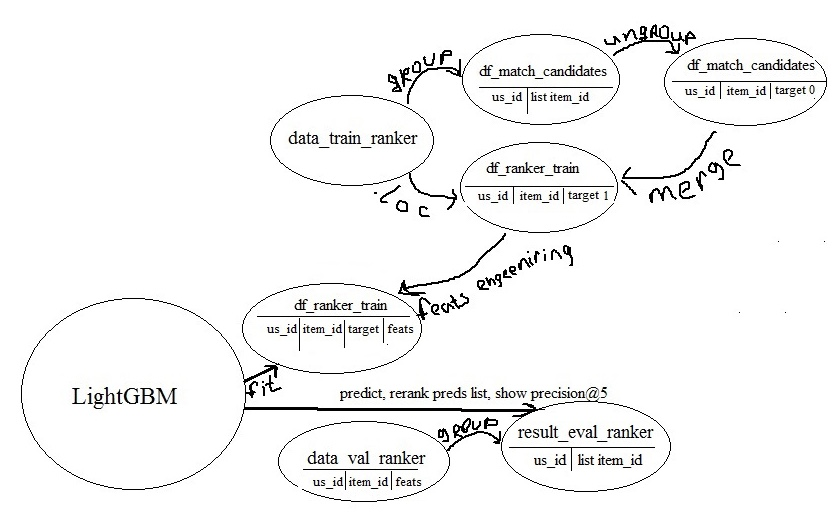

In [16]:
# Схема алгоритма подготовки данных для модели 2-го уровня:
display.Image('./scheme2.JPG', width=850)

In [17]:
N_PREDICT = 500

# взяли пользователей из трейна для ранжирования.  кандидат- это имеется ввиду item_id рекомендация
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем  item_id-кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
# get_own_recommendations из recommender = MainRecommender(...)  выдает для каждого юзера 
# N рекомендаций item_id с учетом разбавления top-N товарами, где это нужно

# тремя следующими строками мы разворачиваем сгруппированный датафрейм в список пар юзер - товар
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

# Создаем трейн сет для ранжирования 
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()

# все что юзер реально купил будет классом 1
df_ranker_train['target'] = 1 
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

# все что мы нарекомендовали и присоедили к df_ranker_train (рекомендованные, но не купленные) метим классом 0
df_ranker_train['target'].fillna(0, inplace= True)


df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1137483,0.0
1,2070,10457532,0.0


In [18]:
# смотрим соотношение классов
df_ranker_train.target.value_counts()

0.0    970764
1.0     26113
Name: target, dtype: int64

df_ranker_train как видим выше не содержит каких-либо фичей.

Его нужно наполнить признаками(future engineering), чтобы модели МО было на чем учиться

In [19]:
# Заполняю стандартными фичами 
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

__Перед созданием новых парных признаков интересно проверить качество работы модели без них:__

In [20]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

X_train_copy = X_train.copy()
cat_feats = [i for i in X_train.columns if X_train[i].dtype == 'object']


# Преобразовываю объекты в категориальные признаки
X_train_copy[cat_feats] = X_train[cat_feats].astype('category')

lgb = LGBMClassifier(objective='binary',
                     max_depth=6, 
                     n_estimators=500, 
                     learning_rate=0.001, 
                     categorical_column=cat_feats,
                     n_jobs=-1,
                   )

lgb.fit(X_train_copy, np.ravel(y_train,order='C'))

train_preds = lgb.predict_proba(X_train_copy)


def rerank(user_id, res_table):
    return res_table[res_table[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

TOPK_PRECISION = 5
predicts = df_ranker_train.copy()
predicts['proba_item_purchase'] = train_preds[:,1]

results_table = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
results_table.columns=[USER_COL, ACTUAL_COL]

results_table['own_rec'] = results_table[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
results_table['reranked_own_rec'] = results_table[USER_COL].apply(lambda user_id: rerank(user_id, predicts))

print(*sorted(calc_precision(results_table, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

/home/kakorinis/anaconda3/envs/recsystems/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


('reranked_own_rec', 0.09464285714285714)
('own_rec', 0.04948250369640217)


/tmp/ipykernel_6312/493078646.py:58: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


__Создаю новые парные фичи:__                                                                          

In [21]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [22]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [23]:
# сделаем объединенный сет данных - все что было до последних 3 недель (данные с трейна и теста первой модели)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])
df_join_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0
11,1364,26984896261,1,842930,1,2.19,31742,0.0,1520,1,0.0,0.0


In [24]:
#  пару категорий нужно внести чтобы сделать связки с ними
df_join_train_matcher = df_join_train_matcher.merge(item_features.loc[:,['department', 'item_id']], how='left',on=[ITEM_COL])
df_join_train_matcher = df_join_train_matcher.merge(item_features.loc[:,['brand', 'item_id']], how='left',on=[ITEM_COL])

In [25]:
#создаю фичу кол-ва покупок юзера в рамках каждой категории товаров (а-ля ранжирую категории по каждому юзеру)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('quantity').sum().rename('total_sales_in_deps'), how='left',on=[USER_COL,'department'])

#создаю фичу ср. цены покупки юзера в рамках каждой категории товаров 
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('sales_value').mean().rename('mean_price_in_deps'), how='left',on=[USER_COL,'department'])

#создаю фичу кол-ва покупок каждого товара для каждого юзера (персональный топ товаров)
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('total_user_item_quantity'), how='left',on=[USER_COL,ITEM_COL])


In [26]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_sales_in_deps,mean_price_in_deps,total_user_item_quantity
0,2070,1137483,0.0,236,GROCERY,National,FROZEN PIE/DESSERTS,FRZN PIE SHELLS PASTRY SHELL,2-12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,483.0,3.339657,1.0
1,2070,10457532,0.0,69,GROCERY,Private,COLD CEREAL,KIDS CEREAL,13 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,483.0,3.339657,3.0


In [27]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996877 entries, 0 to 996876
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   996877 non-null  int64  
 1   item_id                   996877 non-null  int64  
 2   manufacturer              996877 non-null  int64  
 3   department                996877 non-null  object 
 4   brand                     996877 non-null  object 
 5   commodity_desc            996877 non-null  object 
 6   sub_commodity_desc        996877 non-null  object 
 7   curr_size_of_product      996877 non-null  object 
 8   age_desc                  361980 non-null  object 
 9   marital_status_code       361980 non-null  object 
 10  income_desc               361980 non-null  object 
 11  homeowner_desc            361980 non-null  object 
 12  hh_comp_desc              361980 non-null  object 
 13  household_size_desc       361980 non-null  o

In [29]:
# МАСШТАБИРУЮ новые колич. признаки
X_train_copy = X_train.copy()

cat_feats = [i for i in X_train.columns if X_train[i].dtype == 'object']
num_feats = ['total_sales_in_deps', 'mean_price_in_deps','total_user_item_quantity']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X_train_copy[num_feats]) # здесь массив нампай без названий колонок
X_train_copy[num_feats] = scaled_data # возвращаю названия колонок и остальные признаки

#------------------------------ если не масштабировать числовые и все загонять в категориальные, хуже скор, 
#                                                                                     да и неправильно это
# cat_feats =  X_train.columns[2:].tolist()

# Преобразовываю объекты в категориальные признаки
X_train_copy[cat_feats] = X_train[cat_feats].astype('category')

In [30]:
for i in num_feats:
    X_train_copy[i].fillna(0, inplace=True)

### Инициализирую модель второго уровня:

In [31]:
%%time

lgb = LGBMClassifier(objective='binary',
                     max_depth=6, 
                     n_estimators=500, 
                     learning_rate=0.001, 
                     categorical_column=cat_feats,
                     n_jobs=-1,
                   )

lgb.fit(X_train_copy, np.ravel(y_train,order='C'))

train_preds = lgb.predict_proba(X_train_copy)

/home/kakorinis/anaconda3/envs/recsystems/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: user 3min 46s, sys: 656 ms, total: 3min 47s
Wall time: 1min 2s


In [32]:
# функция ранжирования
def rerank(user_id, res_table):
    return res_table[res_table[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

TOPK_PRECISION = 5
predicts = df_ranker_train.copy()
predicts['proba_item_purchase'] = train_preds[:,1]

results_table = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
results_table.columns=[USER_COL, ACTUAL_COL]

results_table['own_rec'] = results_table[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
results_table['reranked_own_rec'] = results_table[USER_COL].apply(lambda user_id: rerank(user_id, predicts))

print(*sorted(calc_precision(results_table, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

/tmp/ipykernel_6312/493078646.py:58: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('reranked_own_rec', 0.2803571428571429)
('own_rec', 0.04948250369640217)


#### Как видим модель второго уровня улучшила точность с 6 до 28%

### Приступим к проверке работы алгоритма на тестовом датасете:

In [33]:
data_test = pd.read_csv('/home/kakorinis/Desktop/GB/GeekBrains/II четверть/Рекомендательные системы/уроки с картинками/course_project/retail_test1.csv')

data_test.shape

(88734, 12)

In [34]:
data_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


__Отсеиваю холодных юзеров аналогично как это делалось на обучении:__

In [35]:
# применяю тот же подход, что и на обучения по холодным юзерам
data_test = data_test[data_test.user_id.isin(common_users)]

data_test.shape

(88403, 12)

__Если включить этот блок, то 'reranked_own_rec' = 0.245, что показывает приемлемое переобучение от 28% на трейне__

In [36]:
# убираем новые айтемы, неизвестные на обучении
# common_items = data_train_matcher.item_id.unique()
# data_test = data_test[data_test.item_id.isin(common_items)]

# data_test.shape
# -----------------
# (30548, 12)

##### Data_test нужно также как и data_train_matcher преобразовать в сет с таргетами и фичами:

In [37]:
# Создаем из тестовых данных тестовый датасет для ранжирования
df_test = data_test[[USER_COL, ITEM_COL]].copy()

# все что юзер в тестовых данных реально купил будет 1-ым классом
df_test['target'] = 1 
df_test = df_match_candidates.merge(df_test, on=[USER_COL, ITEM_COL], how='left') 
# df_match_candidates  используем тот же, т.к. это список рекомендаций по итогам первой модели

# чистим дубликаты
df_test = df_test.drop_duplicates(subset=[USER_COL, ITEM_COL])

# все что мы нарекомендовали и присоедили к из df_match_candidates метиим 0 классом
df_test['target'].fillna(0, inplace= True)


df_test.head(2)

,user_id,item_id,target
0,2070,1137483,0.0
1,2070,10457532,0.0


In [38]:
# Заполняю стандартными фичами 
df_test = df_test.merge(item_features, on='item_id', how='left')
df_test = df_test.merge(user_features, on='user_id', how='left')
df_test.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1137483,0.0,236,GROCERY,National,FROZEN PIE/DESSERTS,FRZN PIE SHELLS PASTRY SHELL,2-12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,10457532,0.0,69,GROCERY,Private,COLD CEREAL,KIDS CEREAL,13 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [39]:
#создаю фичу кол-ва покупок юзера в рамках каждой категории товаров (а-ля ранжирую категории по каждому юзеру)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('quantity').sum().rename('total_sales_in_deps'), how='left',on=[USER_COL,'department'])

#создаю фичу ср. цены покупки юзера в рамках каждой категории товаров 
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('sales_value').mean().rename('mean_price_in_deps'), how='left',on=[USER_COL,'department'])

#создаю фичу кол-ва покупок каждого товара для каждого юзера (персональный топ товаров)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('total_user_item_quantity'), how='left',on=[USER_COL,ITEM_COL])

In [40]:
df_test.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_sales_in_deps,mean_price_in_deps,total_user_item_quantity
0,2070,1137483,0.0,236,GROCERY,National,FROZEN PIE/DESSERTS,FRZN PIE SHELLS PASTRY SHELL,2-12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,483.0,3.339657,1.0
1,2070,10457532,0.0,69,GROCERY,Private,COLD CEREAL,KIDS CEREAL,13 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,483.0,3.339657,3.0


In [41]:
X_test = df_test.drop('target', axis=1)
y_test = df_test[['target']]

In [42]:
# Повторяем препроцесинг для теста
from sklearn.preprocessing import MinMaxScaler

X_test_copy = X_test.copy()
cat_feats = [i for i in X_test_copy.columns if X_test_copy[i].dtype == 'object']

num_feats = ['total_sales_in_deps','total_user_item_quantity', 'mean_price_in_deps']
scaler = MinMaxScaler()

scaled_test_data = scaler.fit_transform(X_test_copy[num_feats]) 
X_test_copy[num_feats] = scaled_test_data 


X_test_copy[cat_feats] = X_test_copy[cat_feats].astype('category')

In [43]:
for i in num_feats:
    X_test_copy[i].fillna(0, inplace=True)

In [44]:
result_test_table = data_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test_table.columns=[USER_COL, ACTUAL_COL]
result_test_table.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


__Проверяю точность предсказания рекомендаций двухуровневой модели:__

In [45]:
test_preds = lgb.predict_proba(X_test_copy)


def rerank(user_id, res_table):
    return res_table[res_table[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

TOPK_PRECISION = 5
predicts = df_test.copy()
predicts['proba_item_purchase'] = test_preds[:,1]


result_test_table['own_rec'] = result_test_table[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_test_table['reranked_own_rec'] = result_test_table[USER_COL].apply(lambda user_id: rerank(user_id, predicts))

print(*sorted(calc_precision(result_test_table, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.2314835787089468)
('own_rec', 0.03890967397113843)


/tmp/ipykernel_6312/493078646.py:58: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


## ЧТО НЕ ПОЛУЧИЛОСЬ:

### 1. Изменять топ-5000

По условиям префильтра на выход идет немногим менее 6000 товаров, потому никак нельзя сделать 7, 8, 10 тыс. товаров.<br>
Пробовал брать меньше 5 тыс. - показатели точности падали.

Менять условия обрезки не стал, т.к. больше хотелось уделить время на остальной процесс.

In [ ]:
# ПОДБИРАТЬ take_n_popular в большую сторону не получится т.к. условия обрезки префильтра выдают 5870 айтемов
%%time

# ищем лучший take_n_popular
take_n_popular_list = [ 5000, 7000, 10000]
TOPK_RECALL = [50, 500]
N_PREDICT = [50,  500]

res2 = pd.DataFrame(columns=['n_popular', 'own_rec'])

for i in take_n_popular_list:
    
    
    
    data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]
    data_train_match = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=i)
    
    common_users = data_train_match.user_id.values

    data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
    data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
    data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]
  
    recommender = MainRecommender(data_train_match)
    N_PREDICT = 500 #500
    

    result_eval_match = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_match.columns=[USER_COL, ACTUAL_COL]
    
    result_eval_match['own_rec'] = result_eval_match[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
   
    result_list = sorted(calc_recall(result_eval_match, 500), key=lambda x: x[1],reverse=True)
    dict_result = dict(result_list) # ввожу словарь, чтобы при переписывании не произошло ошибки
    res2 = res2.append({
        'n_popular': i,
        'own_rec': dict_result['own_rec']
    }, ignore_index=True)
    
res2  

### 2. Потестить различные веса в user-item матрице (0/1,  log(кол-во покупок + 1))

Пробовал только указывать quantity и value_sales, с последним модель отрабатывала хуже.
Как впихнуть параметр log(кол-во покупок + 1) не понял.

### 3. Использовать разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры) - рекомендация лектора

Применительно в этой части не понял как в BM25 задавать параметры - в документации к библиотеке implicit не нашел такого

### 4. Использовать GridSearch для тюнинга LGBMClassifier.

Проблема в том, как подать свой кастовый алгоритм расчета точности в параметр scoring.<br>
И в целом как корректно в рекомендашках использовать GridSearch?<br>

Ниже топорный пример подбора через цикл

In [ ]:
%%time

import warnings
warnings.filterwarnings('ignore')

max_depth_param = [6, 8, 10, 12, 15]
n_estimators = [300, 500, 1000]
learning_rate = [0.001, 0.01, 0.1]

res_list_params = []

for depth in max_depth_param:
    for n in n_estimators:
        for rate in learning_rate:
            
            # обнуляю result_eval_ranker
            results_table = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
            results_table.columns=[USER_COL, ACTUAL_COL]

            # запишу результат работы только 1 модели
            results_table['own_rec'] = results_table[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
            results_table.head(2)


            lgb = LGBMClassifier(objective='binary',
                     max_depth=depth,
                     n_estimators=n,
                     learning_rate=rate,
                     categorical_column=cat_feats,
                     n_jobs=-1
                   )

            lgb.fit(X_train_copy, y_train)

            train_preds = lgb.predict_proba(X_train_copy)
            df_preds = df_ranker_train.copy()
            df_preds['proba_item_purchase'] = train_preds[:,1]
            
            results_table['reranked_own_rec'] = results_table[USER_COL].apply(lambda user_id: rerank(user_id, df_preds))
            
            res = sorted(calc_precision(results_table, TOPK_PRECISION), key=lambda x: x[1], reverse=True)
            
            params_dict = {
                'max_depth': depth,
                'n_estimators': n,
                'learning_rate': rate
            }
            res_list_params.append((res, params_dict))

sorted(res_list_params,key=lambda x: x[0][1], reverse=True)[-1]

In [ ]:
# other method to search the best params
from hyperopt import fmin, tpe, hp, Trials

space = [hp.randint('N', 90, 200),
         hp.uniform('regular', 0.001, 0.05),
         hp.randint('IT', 40, 80)]
mmm=0
def f(args):
    N, regular ,IT = args
    
    
    model = AlternatingLeastSquares(factors=N, 
                                regularization=regular,
                                iterations=IT, 
                                calculate_training_loss=True, 
                                num_threads=0)


    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    mmm=+1
    result['BPR_test_'+str(mmm)] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=50))
    PRECISION=result.apply(lambda row: precision_at_k(row['BPR_test_'+str(mmm)], row['actual'], k=50), axis=1).mean()
    print(f'PRECISION= {PRECISION} and N, regular ,IT= {N, regular ,IT}')
    
    return 1-PRECISION

In [ ]:
%%time

trials = Trials()

best = fmin(f, space, algo = tpe.suggest, max_evals=15, trials=trials)
print ('TPE result: ', best)

### 5. Оптимально выбрать n-кандидатов

Пришлось брать 500, т.к. с меньшим числом точность все же падала.

При N_Predict = 100 точность на трейне по 'reranked_own_rec' упала с 0.28 до 0.206, а на тесте с 0.231 до 0.17

In [ ]:
# здесь метрика полноты, понятно что она то растет, но точность на тесте получается хуже если кандидатов не 500
%%time

TOPK_RECALL = [50,100, 500]
N_PREDICT =[50,100, 500]

res = pd.DataFrame(columns=['k_candidades', 'topk_recall','own_rec', 'als_rec','sim_item_rec'])
for i in N_PREDICT:
    
    main_data_result_list = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    main_data_result_list.columns=[USER_COL, ACTUAL_COL]
    main_data_result_list['own_rec'] = main_data_result_list[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=i))
    main_data_result_list['sim_item_rec'] = main_data_result_list[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=i))
    main_data_result_list['als_rec'] = main_data_result_list[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=i))
    
    result_list = sorted(calc_recall(main_data_result_list, i), key=lambda x: x[1],reverse=True)
    dict_result = dict(result_list) # ввожу словарь, чтобы при переписывании не произошло ошибки
    res = res.append({
        'k_candidades': i,
        'topk_recall': i,
        'own_rec': dict_result['own_rec'],
        'als_rec': dict_result['als_rec'],
        'sim_item_rec': dict_result['sim_item_rec']}, ignore_index=True)
res

### 6. Feauture ingeneering

Пробовал добавлять фичи ниже и точность в итоге упала до меньше чем 5% на трейновых данных. Оставил лишь 3 новых фичи

In [ ]:
# фича популярности департамента среди общей массы пользователей
df_test = df_test.merge(df_join_train_matcher.groupby(by='department').agg('quantity').sum().rename('common_dep_sales'), how='left',on='department')


# создаю фичу любимого бренда (кол-во покупок по бренду)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'brand']).agg('quantity').sum().rename('favourite_user_brand'), how='left',on=[USER_COL,'brand'])

# создаю фичу суммы покупок каждого товара для каждого юзера (персональный топ товаров)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('sales_value').sum().rename('total_user_item_sales_value'), how='left',on=[USER_COL,ITEM_COL])

# создаю фичу кол-ва покупок каждого товара для каждого юзера (персональный топ товаров)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, ITEM_COL]).agg('quantity').sum().rename('total_user_item_quantity'), how='left',on=[USER_COL,ITEM_COL])

# создаю фичу ср. цены покупки юзера в рамках всех купленных товаров
df_test = df_test.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').mean().rename('mean_price_common'), how='left',on=USER_COL)


# создаю фичу ср. цены покупки юзера в рамках каждой категории товаров 
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('sales_value').mean().rename('mean_price_in_deps'), how='left',on=[USER_COL,'department'])

# создаю фичу общей суммы покупок юзера в рамках каждой категории товаров 
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('sales_value').sum().rename('total_value_sales_in_deps'), how='left',on=[USER_COL,'department'])

# создаю фичу кол-ва покупок юзера в рамках каждой категории товаров (а-ля ранжирую категории по каждому юзеру)
df_test = df_test.merge(df_join_train_matcher.groupby(by=[USER_COL, 'department']).agg('quantity').sum().rename('total_sales_in_deps'), how='left',on=[USER_COL,'department'])

df_test['common_dep_sales'] = df_test['common_dep_sales'].astype(float)

In [ ]:
# # Цена делается и в префильтре, но я ее заводил отдельно 

# dw = df_join_train_matcher.groupby(by=ITEM_COL).agg({'quantity': ['sum'],'sales_value': ['sum']})
# dw.columns=['quantity', 'sales_value']
# dw['price'] = 0
# dw['item_id'] = dw.index
# dw['price'] = dw.sales_value.values / dw.quantity.values
# dw = dw.fillna(0)


# df_ranker_train = df_ranker_train.merge(dw.price, how='left',on=ITEM_COL)
# # ПО ИТОГУ НЕ ИЗМЕНИЛОСЬ НИЧЕГО